In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nltk.corpus import stopwords       
from nltk.stem import PorterStemmer       
import re
from pdfminer.high_level import extract_text
import nltk
from nltk.tokenize import word_tokenize
import string
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yasme\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yasme\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
data = pd.read_csv("jobs.csv")

data.dropna(subset=["job_description"],inplace=True)
data.dropna(subset=["job_requirement"],inplace=True)

data["Info"] = data.job_description + data.job_requirement

swe = data[data["job_title"]=='Software Engineer']
web = data[data["job_title"]=='Web Developer']
flutter = data[data["job_title"]=='Flutter Developer']
Acc = data[data["job_title"]=='Accountant']
cs = data[data["job_title"]=='Customer Service']
ce = data[data["job_title"]=='Civil Engineer']

swe_data = swe["Info"].to_list()
web_data =web["Info"].to_list()
flutter_data =flutter["Info"].to_list()
Acc_data = Acc["Info"].to_list()
cs_data = cs["Info"].to_list()
ce_data = ce["Info"].to_list()

## First approach: Keywords matching 

In [5]:
def text_preprocessing(text: list,
        punctuations=r'''!()-[]{};:'"\,<>./?@$%^&*_“~''',
        stop_words=['and', 'a', 'is', 'the', 'in', 'be', 'will', 'was', 'but', 'this', 'were', 'with', 'of', 'also',
                    'on', '.', 'for', 'any', 'its', 'and', 'are', 'from', 'both', 'as','or','so','their','only','can',
                    'now','A','much','could','usually',"to",'that','them','$','§','”','at','●','←','…','•','–']
) -> list:
    
    for x in text.lower():
        if x in punctuations:
            text = text.replace(x, "")
    ## remove stop words, numbers, punctuation
    text = re.sub(r'\w*\d\w*', '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.lower()
    text = text.split(' ')
    text = [x for x in text if x != '']
    text = [x for x in text if x not in stop_words]
    
    ## stem the words
    stemmedList = []
    stemmer = PorterStemmer() 
    for word in text :
        stemmedList.append(stemmer.stem(word)) 
    
    ## remove duplicate word in each doc
    text.sort()
    unique_word_list = []
    stopwords_english = stopwords.words('english') 
    for word in stemmedList:
        if( word not in unique_word_list and word not in stopwords_english):
            unique_word_list.append(word)

    return unique_word_list

def Words(classWords):
    words = []
    for x in classWords:
        words.append( text_preprocessing(x))
    
    merged_list = [item for sublist in words for item in sublist]
    final = []
    for ww in merged_list:
        if ww not in final:
            final.append(ww)
    
    return final

In [6]:
def CV_score(classWords,CV_words):
    counter = 0
    for w1 in CV_words:
        for w2 in classWords:
                if w1 == w2 :
                    counter+=1
    result = (counter/len(classWords))
    return result

In [7]:
swe_words = Words(swe_data)
acc_word = Words(Acc_data)
web_words = Words(web_data)
cs_words = Words(cs_data)
flutter_words = Words(flutter_data)
ce_words = Words(ce_data)

cv = extract_text("Yasmine Saber.pdf")
cv_words = text_preprocessing(cv)

In [8]:
titles = data["job_title"].unique()
print(titles)

['Software Engineer' 'Web Developer' 'Flutter Developer' 'Accountant'
 'Customer Service' 'Civil Engineer']


In [9]:
swe_score = CV_score(swe_words,cv_words)
web_score = CV_score(web_words,cv_words)
flutter_score = CV_score(flutter_words,cv_words)
acc_score = CV_score(acc_word,cv_words)
cs_score = CV_score(cs_words,cv_words)
ce_score = CV_score(ce_words,cv_words)

Scores = []
Scores.append(swe_score)
Scores.append(web_score)
Scores.append(flutter_score)
Scores.append(acc_score)
Scores.append(cs_score)
Scores.append(ce_score)

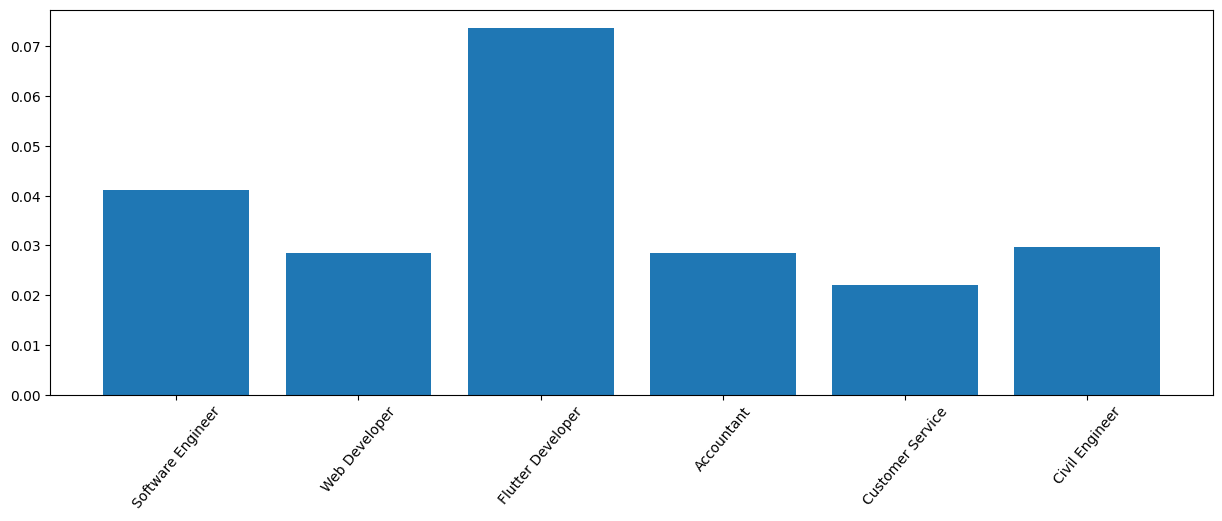

In [10]:
plt.figure(figsize=(15,5))
plt.bar(titles,Scores)
plt.xticks(rotation = 50)
plt.show()

## Second approach: Tf-idf matching

In [11]:
def preprocess_document(document):
    # Tokenization
    tokens = word_tokenize(document)
    # Lowercase conversion
    tokens = [token.lower() for token in tokens]
    # Punctuation removal
    tokens = [token for token in tokens if token not in string.punctuation]
    # Stop word removal
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    return " ".join(tokens)
 
documents = np.array(data["Info"])
preprocessed_documents = [preprocess_document(document) for document in documents]

In [ ]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(preprocessed_documents)
 
# Convert TF-IDF document term matrix to DataFrame
feature_names = vectorizer.get_feature_names_out()
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
 
# print("\nTF-IDF DataFrame:")
# print(df_tfidf)

In [ ]:
new_preprocessed_document = preprocess_document(cv)
new_tfidf_vector = vectorizer.transform([new_preprocessed_document])
 
# Convert TF-IDF matrix to DataFrame
feature_names = vectorizer.get_feature_names_out()
df_tfidf_new = pd.DataFrame(new_tfidf_vector.toarray(), columns=feature_names)

# print("\nTF-IDF DataFrame:")
# print(df_tfidf_new)

In [ ]:
similarity_scores = cosine_similarity(new_tfidf_vector, tfidf_matrix)
copy_Score2 = similarity_scores[0].copy()
sorted = np.sort(-copy_Score2)
maxTen = sorted[0] * -1
index = np.where(similarity_scores[0]==maxTen)
job = data.iloc[index[0][0]]["job_title"]
print("the most appropriate job is:",job)

the most appropriate job is: Software Engineer
